In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

# 短语情感分类

对Phrase字段中的文本进行分类，分类结果为

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [3]:
train.sample(20)

,PhraseId,SentenceId,Phrase,Sentiment
61451,61452,3106,Enticing and often,3
104420,104421,5510,the heart of the boy,2
95754,95755,5001,"its central figure ,",2
53777,53778,2670,"this new jangle of noise , mayhem and stupidity",0
109284,109285,5787,riveting documentary .,4
112663,112664,5982,brought off with considerable wit,4
17,18,1,what is good for the goose,2
82674,82675,4269,Not all of the stories work and the ones that ...,0
33625,33626,1577,expert thriller,4
19603,19604,861,"seen in a while , a meander through worn-out m...",1


## 数据预处理
1. 统计单词频率并保留频率最高的1000个单词，构建单词到索引的映射，以及构建索引到单词的映射。

In [4]:
# 使用部分数据
# train = train.head(1000)

# 创建字典
len_list = []
word_freq_map = defaultdict(int)
for sentence in train.Phrase:
    words = sentence.split()
    words = [w.lower() for w in words] # 统一为小写
    len_list.append(len(words))
    for word in words:
        word_freq_map[word] += 1

word_freq_map = dict(sorted(word_freq_map.items(),
                                   key=lambda x: x[1], reverse=True))
top_k_words = 2000
# 使用列表根据序号查找单词 (特殊词 <UNK> 表示未登录词)
idx2word = list(word_freq_map.keys())[:top_k_words] + ['<UNK>'] # 
# 使用词典根据单词查找序号
word2idx = {idx2word[i]:i for i in range(len(idx2word))}
print('<UNK>:', word2idx['<UNK>'])

<UNK>: 2000


2. 构建基于Bag-of-Words的数据集

In [5]:
# Bag of Words dataset 
def extract_BoW_feat(df, idx2word, word2idx):
    X = []
    for sentence in df.Phrase:
        x = np.zeros(len(idx2word)) # BoW不需要不考虑<PAD>
        words = sentence.split()
        words = [w.lower() for w in words]
        for w in words:
            if w in word2idx:
                x[word2idx[w]]+=1
            else:
                x[word2idx['<UNK>']]+=1
        X.append(x)
    X = np.array(X)
    y = np.array(df.Sentiment)
    return X, y

In [6]:
X,y = extract_BoW_feat(train, idx2word, word2idx)

In [7]:
train_num = int(len(X) * 0.8)
X_train = X[:train_num]
y_train = y[:train_num]
X_val = X[train_num:]
y_val = y[train_num:]

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# 创建训练与验证数据集
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)

## 构建模型

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_dim, output_dim)  # 5 classes for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x



In [11]:
# Create an instance of the MLP model
model = MLP(top_k_words+1, 100, 5)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 模型训练

In [12]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = (train_correct/len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = (correct / len(val_loader.dataset)) * 100
    val_accuracies.append(val_acc)

    # Print training and validation loss, and validation accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")




Epoch 1/10, Loss: 1.3497, Val Loss: 1.3588, Train Acc: 55.55%, Val Acc: 54.19%
Epoch 2/10, Loss: 1.3213, Val Loss: 1.3391, Train Acc: 58.01%, Val Acc: 55.73%
Epoch 3/10, Loss: 1.2863, Val Loss: 1.3247, Train Acc: 61.59%, Val Acc: 57.41%
Epoch 4/10, Loss: 1.2671, Val Loss: 1.3195, Train Acc: 63.59%, Val Acc: 57.78%
Epoch 5/10, Loss: 1.2512, Val Loss: 1.3194, Train Acc: 65.24%, Val Acc: 57.94%
Epoch 6/10, Loss: 1.2395, Val Loss: 1.3208, Train Acc: 66.45%, Val Acc: 57.76%
Epoch 7/10, Loss: 1.2309, Val Loss: 1.3236, Train Acc: 67.38%, Val Acc: 57.40%
Epoch 8/10, Loss: 1.2236, Val Loss: 1.3245, Train Acc: 68.19%, Val Acc: 57.38%
Epoch 9/10, Loss: 1.2168, Val Loss: 1.3235, Train Acc: 68.89%, Val Acc: 57.45%
Epoch 10/10, Loss: 1.2109, Val Loss: 1.3251, Train Acc: 69.48%, Val Acc: 57.28%


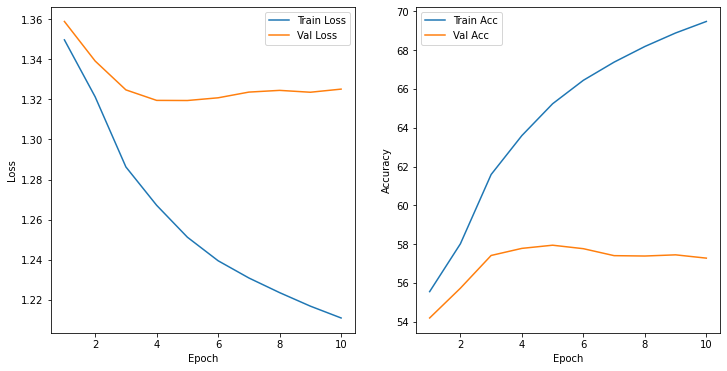

In [13]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 生成测试结果

In [14]:
test = pd.read_csv('test.tsv', sep='\t')
test.sample(5)

,PhraseId,SentenceId,Phrase
65873,221934,11828,sand
59660,215721,11493,gazing out windows
63592,219653,11704,Egoyan 's
65933,221994,11833,fu pictures
37018,193079,10270,wo n't stand the test of time


In [15]:
test['Sentiment'] = 0 # add fake label
X_test,y_test = extract_BoW_feat(test, idx2word, word2idx)

In [16]:
test_dataset = SentimentDataset(X_test, y_test)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
all_predicted = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predicted.append(predicted.numpy())
y_test = np.concatenate(all_predicted)

In [17]:
test['Sentiment']=y_test
selected_columns = ['PhraseId', 'Sentiment']
test[selected_columns].to_csv('Sentiment_BoW_MLP.csv', index=False)